# **STATS 503, Group Work Assignment 7: Trees and Tree Ensembles**

**Instructions:** During lab section, and afterward as necessary, you will collaborate in two-person teams (assigned by the GSI) to complete the problems that are interspersed below. The GSI will help individual teams encountering difficulty, make announcements addressing common issues, and help ensure progress for all teams. **During lab, feel free to flag down your GSI to ask questions at any point!** Upon completion, one member of the team should submit their team's work through Canvas as html.

**credits:** Roman Kouznetsov, based on notes from Gabriel Patron and Ji Zhu

##  Classification Trees

A **classification tree** is built through a process known as binary recursive partitioning. The main idea is as follows:
* Recursively partition the input space into rectangular boxes
* At each step, ask a question about one variable (split the feature space into parts)
* Repeat for each branch (recursively partition the feature space into boxes)
* Goal: each box should contain data points mostly from the same class
* Each box is labelled with its majority class
* The end result: a tree of splits, a partitioning of the variable space into boxes and assignment of a class label to each box



Scikit-learn implements CART, whose fundamental principles and methodologies behind its decision tree algorithms are largely based on the concepts introduced by Breiman et al. in the book Classification and Regression Trees.

Additionally, scikit-learn enhances the basic CART algorithm with several modern features like support for missing values, various criteria for splitting (Gini impurity, entropy for classification, and mean squared error, mean absolute error for regression), and pre-pruning options.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests, zipfile, io

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

We look at the spam email classification problem. This dataset is available at this [link](https://archive.ics.uci.edu/ml/datasets/spambase).

In [2]:
url = "https://archive.ics.uci.edu/static/public/94/spambase.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(".")

In [3]:
column_names = [
    "word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d",
    "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet",
    "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will",
    "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free",
    "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit",
    "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money",
    "word_freq_hp", "word_freq_hpl", "word_freq_george", "word_freq_650",
    "word_freq_lab", "word_freq_labs", "word_freq_telnet", "word_freq_857",
    "word_freq_data", "word_freq_415", "word_freq_85", "word_freq_technology",
    "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct",
    "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project",
    "word_freq_re", "word_freq_edu", "word_freq_table", "word_freq_conference",
    "char_freq_;", "char_freq_(", "char_freq_[", "char_freq_!",
    "char_freq_$", "char_freq_#", "capital_run_length_average",
    "capital_run_length_longest", "capital_run_length_total", "is_spam"
]

In [4]:
spam_data = pd.read_csv("spambase.data", names=column_names)

In the dataset, there are 57 continuous variables as input variables and 1 binary outcome variable. The variable information is given as follows:

``word_freq_WORD``: percentage of words in the email that match WORD (48 variables taking value in [0,100]);

``char_freq_CHAR``: percentage of characters in the email that match CHAR (6 variables taking value in [0,100]);

``capital_run_length_average``: average length of uninterrupted sequences of capital letters;

``capital_run_length_longest``: length of longest uninterrupted sequence of capital letters;

``capital_run_length_total``: total number of capital letters in the email;

``spam``: denotes whether the email was considered spam (1) or not (0).


In [5]:
spam_train, spam_test = train_test_split(spam_data, test_size = 0.3, random_state= 1, stratify = spam_data['is_spam'])

Let us take a look at the word frequencies. In a word vector, words appearing too frequently or too rarely can usually be useless for making predictions. We order the first 48 columns accroding to their mean frequency. We will use tree model later to confirm if our intuition is correct.

In [6]:
# Calculate the column mean for the first 48 columns which corresponds to word frequency
word_freq_mean = spam_train.mean(axis=0)[0:48]

# Change the order by the frequency value
word_freq_mean_sort = word_freq_mean.sort_values(ascending=True)
word_freq_mean_sort

,0
word_freq_table,0.005742
word_freq_parts,0.014134
word_freq_conference,0.032447
word_freq_cs,0.043382
word_freq_original,0.045230
word_freq_857,0.046894
word_freq_415,0.047488
word_freq_addresses,0.047941
word_freq_receive,0.057062
word_freq_report,0.062320


It’s interesting to see that the word ``george`` has high frequency. This is because George is the donor of the dataset. We may see later that ``hp``, the place George works, is selected by tree model. We should note that using those two words may causes generalization problem when we apply the model to emails of other users. We also find the labels are slightly unbalanced. This reminds us to adjust the output label distribution when we generalize the model to a broader application.

In [7]:
pd.crosstab(index = spam_train['is_spam'], columns = 'count')

col_0,count
is_spam,
0,1951
1,1269


You can check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for `DecisionTreeClassifier`. Here are some arguments we use:

- ``criterion``: {“gini”, “entropy”, “log_loss”}, default= "gini"

The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "log_loss" and "entropy" both for the Shannon information gain, see Mathematical formulation.

- ``class_weight``: dict, list of dict or "balanced", default=None

Weights associated with classes in the form {class_label: weight}. If None, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.

- ``ccp_alpha``: non-negative float, default=0.0

Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ``ccp_alpha`` will be chosen. By default, no pruning is performed.

We will explain each argument in details later.

In [8]:
X_spam_train = spam_train.drop(['is_spam'], axis=1)
y_spam_train = spam_train['is_spam']
X_spam_test = spam_test.drop(['is_spam'], axis=1)
y_spam_test = spam_test['is_spam']

In [9]:
tree1 = DecisionTreeClassifier(random_state=0)
tree1 = tree1.fit(X_spam_train, y_spam_train)

In [10]:
training_error = 1 -  tree1.score(X_spam_train, y_spam_train)
test_error = 1 -  tree1.score(X_spam_test, y_spam_test)
print('training error is', training_error)
print('test error is', test_error )

training error is 0.00031055900621113075
test error is 0.08327299058653148


One of the most attractive properties of trees is that they can be graphically displayed. We use the ``plot_tree()`` function to depict the tree structure.

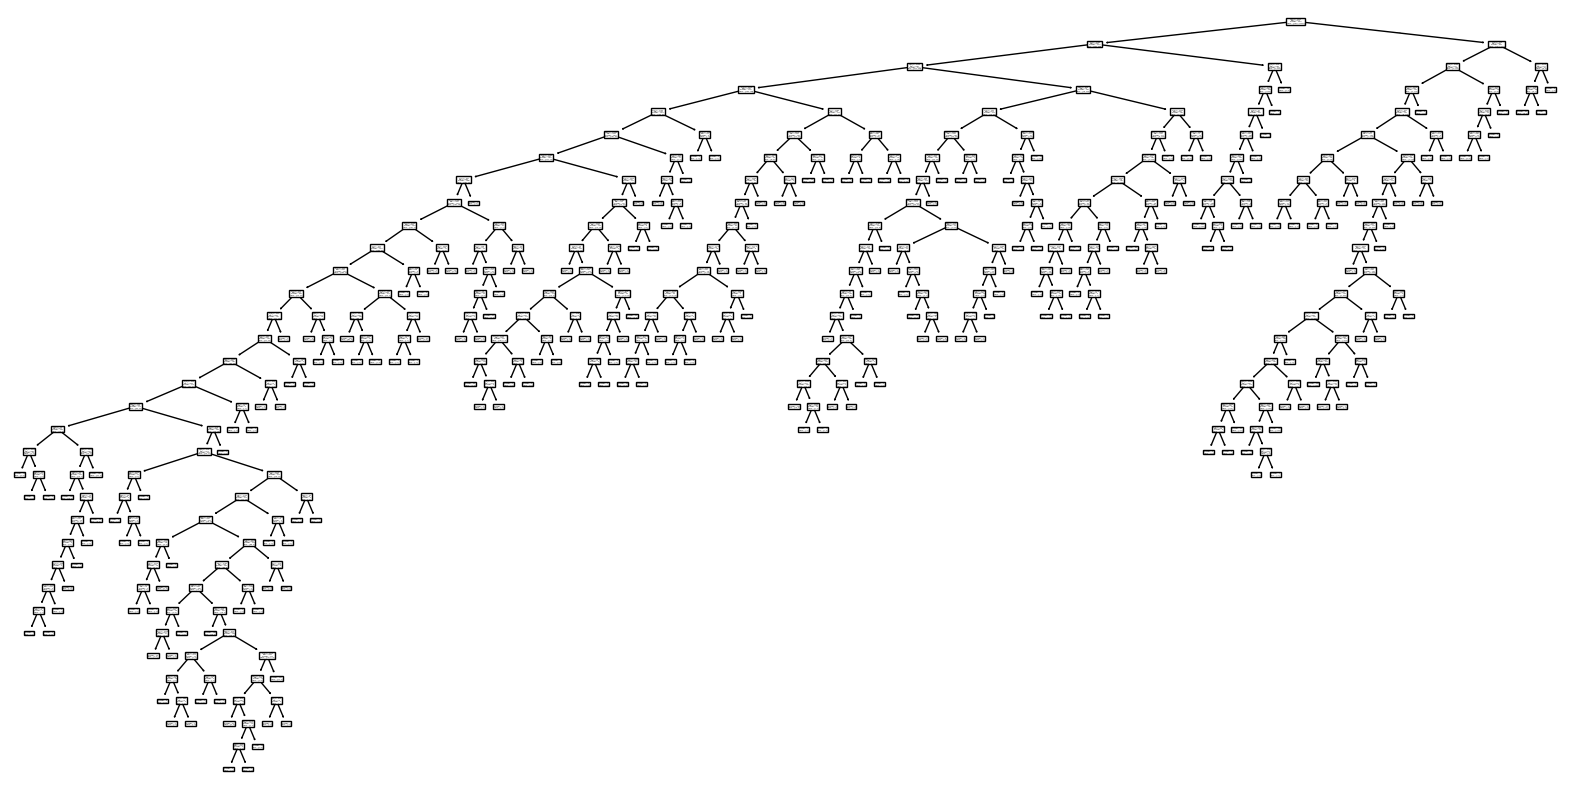

In [11]:
plt.figure(figsize=(20,10))
tree.plot_tree(tree1)
plt.show()

In [12]:
import graphviz

In [13]:
dot_data = tree.export_graphviz(tree1, out_file=None,
                                feature_names=column_names[:-1],
                                class_names=["not_spam", "spam"],
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("Decision Tree", format="png", cleanup=True)  # Save and render the graph as PNG
# graph  # Display the graph

'Decision Tree.png'

Since we didn't penalize the size of the tree, we generated an extremely complex model. The length (or depth) of each branch is proportional to the reduction in impurity (or quality of split) of the corresponding split. There is a very long branch in our complex model.

As mentioned in the lecture, we prune a tree by finding a sub-tree $T$ that minimizes:
$$
  C(T)=\sum_{t=1}^{|T|} N_{t} \cdot \text{Impurity} (t)+c_{p} \cdot|T|.
$$

## Comparing different splitting criterions


There are multiple options for splitting measure. Previously we have implemented Gini index. Now we try the entropy($-\sum_{k=1}^{K} p_{k}(m) \log p_{k}(m)$) splitting measure.

We modify the argument ``criterion`` in ``DecisionTreeClassifier``:

-``criterion``: {“gini”, “entropy”, “log_loss”}, default= ”gini”

Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see [Mathematical formulation](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation).

In [14]:
tree2 = DecisionTreeClassifier(random_state=0, criterion = 'entropy')
tree2 = tree2.fit(X_spam_train, y_spam_train)

training_error = 1 -  tree2.score(X_spam_train, y_spam_train)
test_error = 1 -  tree2.score(X_spam_test, y_spam_test)
print('training error is', training_error)
print('test error is', test_error )

training error is 0.00031055900621113075
test error is 0.057929036929761035


Using cross-entropy, we get smaller test error compared with that we obtained using Gini index.

There are two types of misclassification, i.e. to misclassify ``Spam`` as ``Non-Spam`` and to misclassify ``Non-Spam`` as ``Spam``. The number of two types of errors can be unbalanced.

Our model tends to make the error of predicting ``Spam`` to be ``Non-Spam``, since in our training set ``Non-Spam`` is the dominant class. This can be a problem when we want to control certain type of errors.

We can assign weights to adjust the unbalance to reduce the another type of error. In our case, since training and test set have the same label distribution, the true test error might increase slightly.

To assign weights, we modify the argument ``class_weight`` in ``DecisionTreeClassifier``:

- ``class_weight``: dict, list of dict or “balanced”, default=None

Explanation of this argument: Weights associated with classes in the form {class_label: weight}. If None, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.




In [15]:
y_spam_train.value_counts()

,count
is_spam,
0,1951
1,1269


In [16]:
proportion_non_spam = y_spam_train.value_counts()[0]/y_spam_train.shape[0]
proportion_spam = y_spam_train.value_counts()[1]/y_spam_train.shape[0]
proportion_non_spam/proportion_spam

1.537431048069346

training error is 0.00031055900621113075
test error is 0.08327299058653148


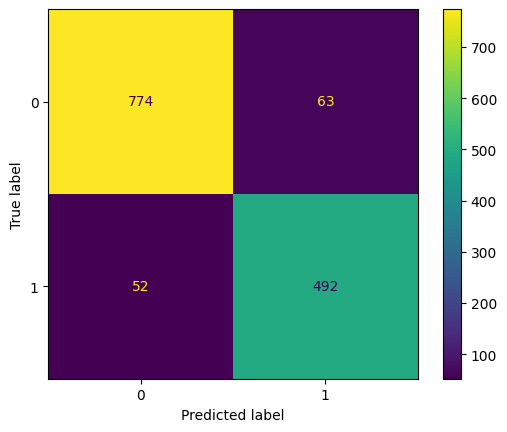

In [17]:
# Model without balancing labels
tree2_no_weight = DecisionTreeClassifier(random_state=0)
tree2_no_weight.fit(X_spam_train, y_spam_train)

training_error = 1 -  tree2_no_weight.score(X_spam_train, y_spam_train)
test_error = 1 -  tree2_no_weight.score(X_spam_test, y_spam_test)

print('training error is', training_error)
print('test error is', test_error)

y_pred_test = tree2_no_weight.predict(X_spam_test)
cm = confusion_matrix(y_spam_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tree2_no_weight.classes_)
cm_display.plot();

training error is 0.00031055900621113075
test error is 0.08327299058653148


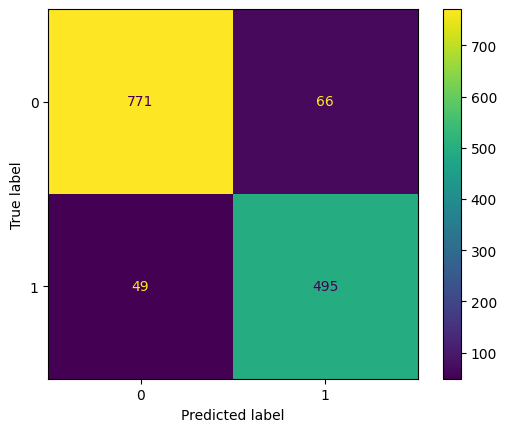

In [18]:
# Model with balancing labels
tree2_weight = DecisionTreeClassifier(random_state=0,
                                      class_weight = {0: 1, 1: proportion_non_spam/proportion_spam})
tree2_weight.fit(X_spam_train, y_spam_train)

training_error = 1 -  tree2_weight.score(X_spam_train, y_spam_train)
test_error = 1 -  tree2_weight.score(X_spam_test, y_spam_test)
print('training error is', training_error)
print('test error is', test_error)

y_pred_test = tree2_weight.predict(X_spam_test)
cm = confusion_matrix(y_spam_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tree2_weight.classes_)
cm_display.plot();

## Regression Trees

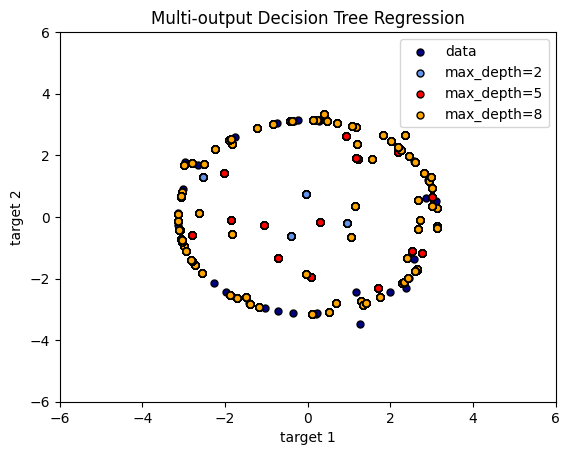

In [19]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(200 * rng.rand(100, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y[::5, :] += 0.5 - rng.rand(20, 2)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=8)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)

# Predict
X_test = np.arange(-100.0, 100.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)

# Plot the results
plt.figure()
s = 25
plt.scatter(y[:, 0], y[:, 1], c="navy", s=s, edgecolor="black", label="data")
plt.scatter(
    y_1[:, 0],
    y_1[:, 1],
    c="cornflowerblue",
    s=s,
    edgecolor="black",
    label="max_depth=2",
)
plt.scatter(y_2[:, 0], y_2[:, 1], c="red", s=s, edgecolor="black", label="max_depth=5")
plt.scatter(
    y_3[:, 0], y_3[:, 1], c="orange", s=s, edgecolor="black", label="max_depth=8"
)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Multi-output Decision Tree Regression")
plt.legend(loc="best")
plt.show()


## Random Forests

A **random forest** is an ensemble method that combines multiple CART for classification and regression tasks. Each CART model is fitted using a bootstrapped sample, just like bagging, but at each split node, only a subset of $m$ predictors of all $p$ features are chosen as candidates for creating the split, typically $m \approx \sqrt{p}$ for classification and $m \approx p/3$ for regression (Section 15.3 of *Elements of Statistical Learning*). Random Forest selects random subsets of features to *decorrelate* trees.




In this section, we will also look at the spam email classification problem using the spam dataset.

RandomForestClassifier in sklearn will be used to implement random forest. Official document could be found here

Note that we could adjust the number of predictors used in random forest by changing the max_features argument.

    max_features: {“sqrt”, “log2”, None}, int or float, default=”sqrt”

The usgae of other arguments such as criterion, ccp_alpha and class_weight are the same as we introduced in DecisionTreeClassifier.


We could fit the bagging model with ``RandomForestClassifier``. Instead of writing a for-loop for bootstrap, we can set the number of predictors used in random forest as the number of all predictors in our training set ($m = p$)

In [20]:
clf = RandomForestClassifier(random_state=0, max_features =  X_spam_train.shape[1])
clf.fit(X_spam_train, y_spam_train)
accuracy = clf.score(X_spam_test, y_spam_test)
test_error_bagging = 1 - accuracy
test_error_bagging

0.04851556842867488

Now we fit random forest, notice that by default, ``max_features``= "sqrt", which means we choose number of features used in random forest $m$ based on the square root of the number of all predictors in our training set $\sqrt{p}$

In [21]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_spam_train, y_spam_train)
accuracy = rf.score(X_spam_test, y_spam_test)
test_error_rf = 1 - accuracy
test_error_rf

0.04779145546705288

## Feature importance based on mean decrease in impurity

Feature importances are provided by the fitted attribute ``feature_importances_`` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. Note that Impurity-based feature importances can be misleading for high cardinality features (many unique values).

In [22]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index= rf.feature_names_in_)

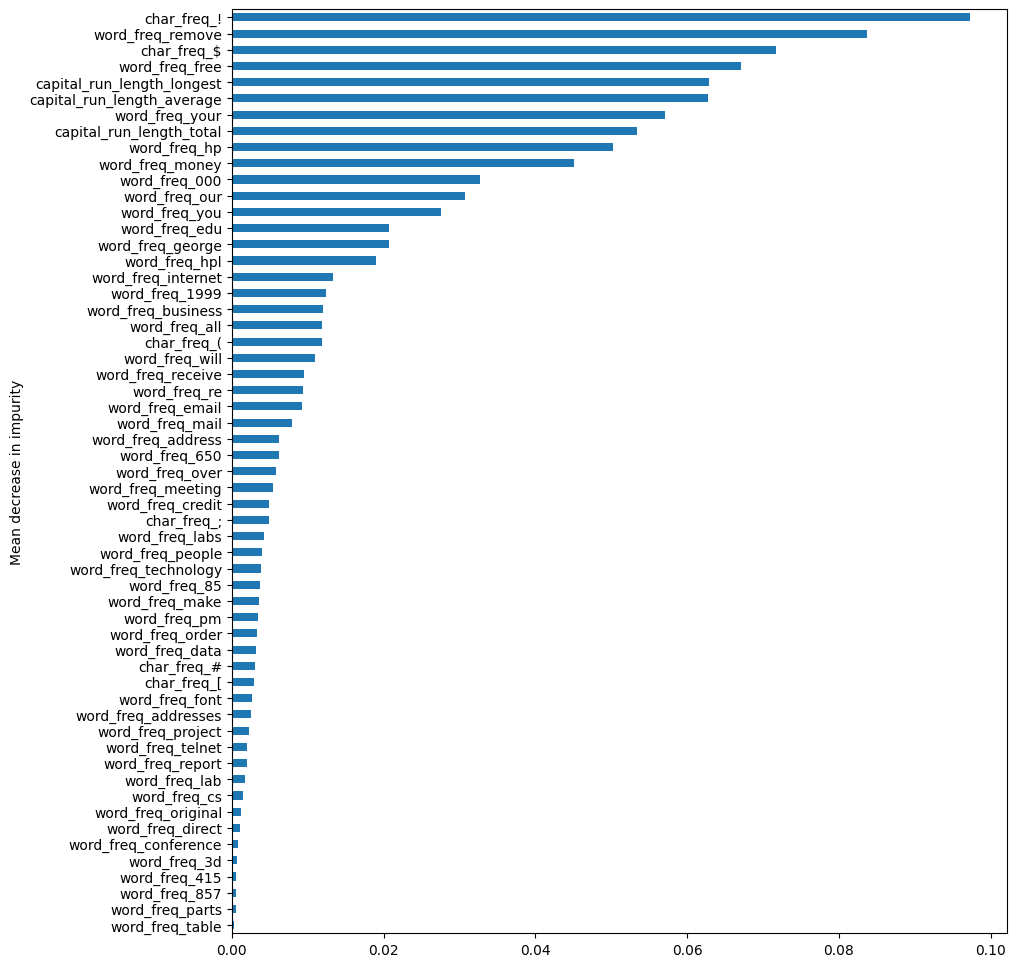

In [23]:
plt.figure(figsize=(10,12))
forest_importances.sort_values(ascending = True).plot.barh()
plt.ylabel("Mean decrease in impurity")
plt.show()

## Feature importance based on feature permutation

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [24]:
from sklearn.inspection import permutation_importance

In [25]:
result = permutation_importance(
    rf, X_spam_test, y_spam_test, n_repeats=10, random_state=42, n_jobs=2
)

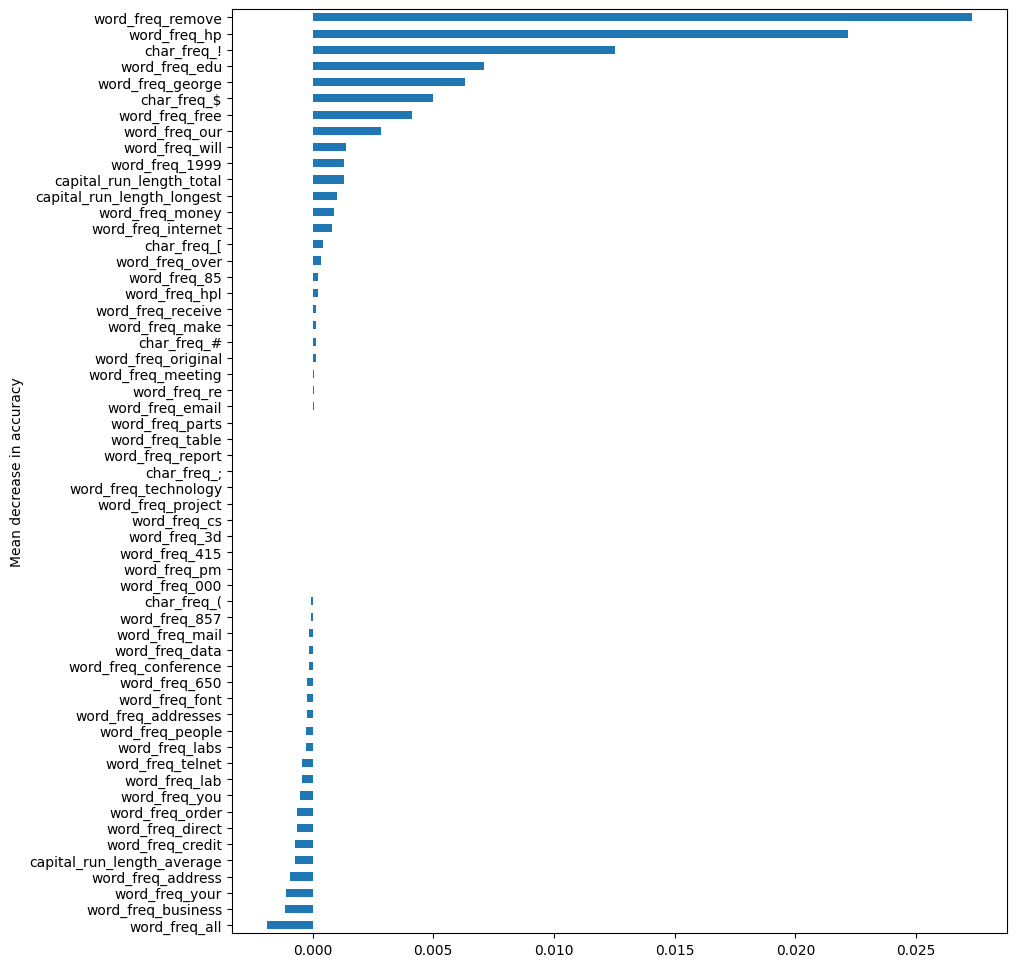

In [26]:
forest_importances = pd.Series(result.importances_mean, index = rf.feature_names_in_)
plt.figure(figsize=(10,12))
forest_importances.sort_values(ascending = True).plot.barh()
plt.ylabel("Mean decrease in accuracy")
plt.show()

We observe some negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate.

## Boosting

A single learned tree may be a bit too restrictive to fully capture patterns in the data. One way to ensure multiple trees get used is with boosting. By using CART as a base learner, gradient boosting trains new iterations of a CART based on the errors of the previous learned models.

$$f_m(x)=f_{m-1}(x)+\left(\underset{h_m \epsilon H}{\operatorname{argmin}}\left[\sum_{i=1}^N L\left(y_i, f_{m-1}\left(x_i\right)+h_m\left(x_i\right)\right)\right]\right)(x)$$

The $m^{\textrm{th}}$ model is an amalgamation of weak learners. Each $h_m$ is a weak learner trained to minimize the remaining error after $f_{m-1}$ is learned.

In [27]:
clf = GradientBoostingClassifier(n_estimators=1000, random_state=0, max_features =  X_spam_train.shape[1])
clf.fit(X_spam_train, y_spam_train)
accuracy = clf.score(X_spam_test, y_spam_test)
test_error_boosting = 1 - accuracy
test_error_boosting

0.04561911658218687

In [28]:
clf = GradientBoostingClassifier(n_estimators=1000, random_state=0, max_features = 'sqrt')
clf.fit(X_spam_train, y_spam_train)
accuracy = clf.score(X_spam_test, y_spam_test)
test_error_boosting = 1 - accuracy
test_error_boosting

0.044895003620564755

# Group Work (30 points)

In this group work assignment, you will be solving both classification and regression problems involving the NHANES dataset.

## Part 1: Motivation (1 point)

In at most **two** sentences, explain whether you expect decision tree
techniques to ourperform our previously covered regression methods **and why**.

---

**ANSWER**: If the data is highly nonlinear or complex, decision tree techniques would generally outperform traidtional regression methods. But if the data size is low or if we have noisy data, the trees might overfit, in which case regression methods would outperform decision trees.

---

## Part 2: Variable Setup and Selection (2 points)

For this problem, we will  try to predict individuals' high-density lipoprotein (HDL) cholesterol levels. For this task please do the following:

1. Use the following features for predictive purposes from our NHANES dataset: Gender, Age, Weight, Height, BMI, WaistSize, Household Size, and Ethnicity. You may need to refer to the docs to figure out their variable names.



*   [HDL_L](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/HDL_L.htm)
*   [DEMO_L](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm)
*   [BMX_L](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BMX_L.htm)



2. **Please** change the variable names to be English-legible but still python variable style.

3. Drop all missing values.

In [29]:
import pandas as pd

### IMPLEMENT HERE

# Load datasets with proper missing value handling
hdl = pd.read_sas('/content/HDL_L.xpt')
demo = pd.read_sas('/content/DEMO_L.xpt')
bmx = pd.read_sas('/content/BMX_L.xpt')

# join on SEQN
df = pd.merge(hdl, bmx, on='SEQN', how='inner')
df = pd.merge(df, demo, on='SEQN', how='inner')
df.head()
# Rename columns to be more readable
my_df = df[[
    "LBDHDD",
    "RIAGENDR",
    "RIDAGEYR",
    "BMXWT",
    "BMXHT",
    "BMXBMI",
    "BMXWAIST",
    "DMDHHSIZ",
    "RIDRETH1"
]]

# Rename columns
my_df.columns = ["HDL", "Gender", "Age", "Weight", "Height", "BMI", "WaistSize", "Household Size", "Ethnicity"]

# Drop rows with missing values
my_df = my_df.dropna()

# Update df
df = my_df
df

,HDL,Gender,Age,Weight,Height,BMI,WaistSize,Household Size,Ethnicity
0,45.0,1.0,43.0,86.9,179.5,27.0,98.3,4.0,5.0
1,60.0,1.0,66.0,101.8,174.2,33.5,114.7,2.0,3.0
2,49.0,2.0,44.0,69.4,152.9,29.7,93.5,7.0,2.0
3,46.0,1.0,34.0,90.6,173.3,30.2,106.1,3.0,1.0
4,42.0,2.0,68.0,103.5,155.9,42.6,122.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...
8059,60.0,1.0,70.0,55.8,161.5,21.4,79.7,2.0,3.0
8060,34.0,2.0,69.0,70.8,159.2,27.9,111.0,2.0,5.0
8062,51.0,2.0,76.0,60.4,151.4,26.4,89.0,4.0,1.0
8066,54.0,1.0,40.0,81.9,179.1,25.5,96.0,5.0,2.0


## Part 3: Train, Val, Test Split (1 point)

Split your data into train, val, test sets into a 60%/20%/20% of observations breakdown, respectively.

**PLEASE USE RANDOM STATE 42 FOR THIS AND ALL SUBSEQUENT QUESTIONS**.

In [30]:
# Ensure missing values are removed before defining X and y
df = df.dropna()

# Define features (X) and target (y)
X = df.drop(columns=["HDL"])  # Features
y = df["HDL"]  # Target variable (1D array)

# Ensure y is a 1D array
y = y.values.ravel()

# Verify shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Now split the data correctly
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print final sizes
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

X shape: (6589, 8), y shape: (6589,)
Train set: (3953, 8), (3953,)
Validation set: (1318, 8), (1318,)
Test set: (1318, 8), (1318,)


## Part 4: Regression Models (5 points)

Train an instance of CART, Random Forest, and Boosting and evaluate its performance on each split of your data.

Ensure to record all of your results and store them in variables. The format should be [SPLIT]\_[METRIC]\_[MODEL NAME]. So, for example, the training loss for CART should be saved under `train_mse_CART`.

**Please display the result as an output to the cell and use a separate for each split/model pair.**.

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Initialize models
cart = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train models
cart.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Make predictions
train_pred_CART = cart.predict(X_train)
val_pred_CART = cart.predict(X_val)
test_pred_CART = cart.predict(X_test)

train_pred_RF = rf.predict(X_train)
val_pred_RF = rf.predict(X_val)
test_pred_RF = rf.predict(X_test)

train_pred_GB = gb.predict(X_train)
val_pred_GB = gb.predict(X_val)
test_pred_GB = gb.predict(X_test)


In [32]:
NHANES_CART = {
    "train_mse_CART": mean_squared_error(y_train, train_pred_CART),
    "val_mse_CART": mean_squared_error(y_val, val_pred_CART),
    "test_mse_CART": mean_squared_error(y_test, test_pred_CART),
}

NHANES_CART

{'train_mse_CART': 0.0,
 'val_mse_CART': 335.66767830045524,
 'test_mse_CART': 308.9226100151745}

In [33]:
NHANES_RF = {
    "train_mse_RF": mean_squared_error(y_train, train_pred_RF),
    "val_mse_RF": mean_squared_error(y_val, val_pred_RF),
    "test_mse_RF": mean_squared_error(y_test, test_pred_RF),
}

NHANES_RF

{'train_mse_RF': 22.66952069314445,
 'val_mse_RF': 155.76048232169956,
 'test_mse_RF': 169.5499626707132}

In [34]:
NHANES_Boosting = {
    "train_mse_GB": mean_squared_error(y_train, train_pred_GB),
    "val_mse_GB": mean_squared_error(y_val, val_pred_GB),
    "test_mse_GB": mean_squared_error(y_test, test_pred_GB),
}

NHANES_Boosting

{'train_mse_GB': 131.04071786366586,
 'val_mse_GB': 145.69118261134963,
 'test_mse_GB': 156.99708286995656}

## Part 5: Regression Results Display (2 points)

We need to compare the performance of the decision tree methods we used. Please create a dataset that has the train, validation, and test errors as the indexes and the method names along the columns. Each element should represent the MSE of the dataset and method. An example format is shown below. Your output should be a `pd.Dataframe` object.


|                    | CART              | Random Forest         | Boosting               |
|--------------------|-------------------|-----------------------|------------------------|
| **Train Error**    | train_mse_CART    | train_mse_RF          | train_mse_Boosting     |
| **Validation Error** | validation_mse_CART | validation_mse_RF  | validation_mse_Boosting |
| **Test Error**     | test_mse_CART     | test_mse_RF           | test_mse_Boosting      |


In [35]:
results_df = pd.DataFrame(
    {
        "CART": [NHANES_CART["train_mse_CART"], NHANES_CART["val_mse_CART"], NHANES_CART["test_mse_CART"]],
        "Random Forest": [NHANES_RF["train_mse_RF"], NHANES_RF["val_mse_RF"], NHANES_RF["test_mse_RF"]],
        "Boosting": [NHANES_Boosting["train_mse_GB"], NHANES_Boosting["val_mse_GB"], NHANES_Boosting["test_mse_GB"]],
    },
    index=["Train Error", "Validation Error", "Test Error"]
)

print(results_df)

                        CART  Random Forest    Boosting
Train Error         0.000000      22.669521  131.040718
Validation Error  335.667678     155.760482  145.691183
Test Error        308.922610     169.549963  156.997083


## Part 6: Switching to Classification (2 points)

Before, we treated HDL as a regression problem. However, sometimes, it can be helpful to view HDL levels in bins and learn to classify the groups. In the past, we predicted individuals that have high-density lipoprotein (HDL) cholesterol of greater than 60. An HDL of 60 **mg/dL** or higher is often viewed as protective against heart disease—this is typically the level you’d like to aim for, if possible.

As it turns out, we can actually group people into "Heart-Healthy", "At-Risk", and "Dangerous". You can see the entire breakdown [here](https://my.clevelandclinic.org/-/scassets/images/org/health/articles/11920-cholesterol-chart.jpg?io=transform:fit,width:780).

Source: [Cleveland Clinic](https://my.clevelandclinic.org/health/articles/11920-cholesterol-numbers-what-do-they-mean)

Based on these definitions, create a new variable named `'Level'` with the labels.  
**Note**: You will need to accommodate males and females having different thresholds.

Also, create a new train, validation, test split with the same percentage breakdown as before, but this time stratifying on y values again. The split objects should be called: `X_train, X_test, X_validation, y_train, y_test, y_validation`

In [36]:
def level_name(gender, hdl):
    """
    Categorizes an individual's HDL level into 'Heart-Healthy' (1), 'At-Risk' (2), or 'Dangerous' (3)
    based on gender-specific thresholds.
    """
    if gender == 1:  # Male
        if hdl >= 60:
            return 0  # Heart-Healthy
        elif hdl >= 40:
            return 1  # At-Risk
        else:
            return 2  # Dangerous
    elif gender == 2:  # Female
        if hdl >= 60:
            return 0  # Heart-Healthy
        elif hdl >= 50:
            return 1  # At-Risk
        else:
            return 2  # Dangerous
    return None  # Catch unexpected cases

my_df = df.copy()

my_df["Level"] = my_df.apply(lambda row: level_name(row["Gender"], row["HDL"]), axis=1)

# Drop any rows with missing Level values (if any)
my_df = my_df.dropna(subset=["Level"])

from sklearn.model_selection import train_test_split

# Ensure HDL is included in all splits
X = my_df[["Gender", "Weight", "Height", "BMI", "WaistSize", "Household Size", "Ethnicity"]]
y = my_df["Level"]  # Target variable

# Split dataset using stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_val, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


# Print dataset sizes
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_validation.shape}, {y_validation.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Train set: (4941, 7), (3705,)
Validation set: (1236, 7), (1236,)
Test set: (1318, 8), (1318,)


In [37]:
assert my_df.iloc[6]['Level'] == 2
assert my_df.iloc[155]['Level'] == 1
assert my_df.iloc[20]['Level'] == 2

## Part 7: Classification Models (5 points)

Similar to what you did for regression, please run CART, Random Forest, and Boosting on all 3 data splits. Ensure to record all of your results and store them in variables. The format should be [SPLIT]\_[METRIC]\_[MODEL NAME]. So, for example, the training accuracy for CART should be saved under `train_acc_CART`.

**Note**: You will be tasked with improving the accuracy to beat a certain threshold so evaluating many models in the training and validation stages may prove useful down the line.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Split dataset using stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Initialize classification models
cart_class = DecisionTreeClassifier(random_state=42)
rf_class = RandomForestClassifier(random_state=42)
gb_class = GradientBoostingClassifier(random_state=42)

# Train models
cart_class.fit(X_train, y_train)
rf_class.fit(X_train, y_train)
gb_class.fit(X_train, y_train)

# Make predictions
train_pred_CART = cart_class.predict(X_train)
val_pred_CART = cart_class.predict(X_val)
test_pred_CART = cart_class.predict(X_test)

train_pred_RF = rf_class.predict(X_train)
val_pred_RF = rf_class.predict(X_val)
test_pred_RF = rf_class.predict(X_test)

train_pred_GB = gb_class.predict(X_train)
val_pred_GB = gb_class.predict(X_val)
test_pred_GB = gb_class.predict(X_test)

# Compute accuracy
train_acc_CART = accuracy_score(y_train, train_pred_CART)
val_acc_CART = accuracy_score(y_val, val_pred_CART)
test_acc_CART = accuracy_score(y_test, test_pred_CART)

train_acc_RF = accuracy_score(y_train, train_pred_RF)
val_acc_RF = accuracy_score(y_val, val_pred_RF)
test_acc_RF = accuracy_score(y_test, test_pred_RF)

train_acc_GB = accuracy_score(y_train, train_pred_GB)
val_acc_GB = accuracy_score(y_val, val_pred_GB)
test_acc_GB = accuracy_score(y_test, test_pred_GB)

# Print results
print(f"Train Accuracy (CART): {train_acc_CART}")
print(f"Validation Accuracy (CART): {val_acc_CART}")
print(f"Test Accuracy (CART): {test_acc_CART}")

print(f"Train Accuracy (RF): {train_acc_RF}")
print(f"Validation Accuracy (RF): {val_acc_RF}")
print(f"Test Accuracy (RF): {test_acc_RF}")

print(f"Train Accuracy (GB): {train_acc_GB}")
print(f"Validation Accuracy (GB): {val_acc_GB}")
print(f"Test Accuracy (GB): {test_acc_GB}")


Train Accuracy (CART): 1.0
Validation Accuracy (CART): 0.42394822006472493
Test Accuracy (CART): 0.48058252427184467
Train Accuracy (RF): 1.0
Validation Accuracy (RF): 0.5032362459546925
Test Accuracy (RF): 0.5388349514563107
Train Accuracy (GB): 0.6112123052013763
Validation Accuracy (GB): 0.5388349514563107
Test Accuracy (GB): 0.5752427184466019


In [39]:
NHANES_CART = {
    "train_acc_CART": train_acc_CART,
    "val_acc_CART": val_acc_CART,
    "test_acc_CART": test_acc_CART,
}

NHANES_RF = {
    "train_acc_RF": train_acc_RF,
    "val_acc_RF": val_acc_RF,
    "test_acc_RF": test_acc_RF,
}

NHANES_Boosting = {
    "train_acc_GB": train_acc_GB,
    "val_acc_GB": val_acc_GB,
    "test_acc_GB": test_acc_GB,
}

# Display results
print("Decision Tree (CART) Results:", NHANES_CART, "\n")
print("Random Forest (RF) Results:", NHANES_RF, "\n")
print("Gradient Boosting (GB) Results:", NHANES_Boosting)

Decision Tree (CART) Results: {'train_acc_CART': 1.0, 'val_acc_CART': 0.42394822006472493, 'test_acc_CART': 0.48058252427184467} 

Random Forest (RF) Results: {'train_acc_RF': 1.0, 'val_acc_RF': 0.5032362459546925, 'test_acc_RF': 0.5388349514563107} 

Gradient Boosting (GB) Results: {'train_acc_GB': 0.6112123052013763, 'val_acc_GB': 0.5388349514563107, 'test_acc_GB': 0.5752427184466019}


## Part 8: Classification Results Display (2 points)

We need to compare the performance of the decision tree methods we used. Please create a dataset that has the train, validation, and test errors as the indexes and the method names along the columns. Each element should represent the accuracy of the dataset and method. Your output should be a `pd.Dataframe` object.

In [40]:
accuracy_data = {
    'CART': [train_acc_CART, val_acc_CART, test_acc_CART],
    'Random Forest': [train_acc_RF, val_acc_RF, test_acc_RF],
    'Gradient Boosting': [train_acc_GB, val_acc_GB, test_acc_GB]
}

# Create DataFrame with 'train', 'validation', 'test' as the index
results_df = pd.DataFrame(accuracy_data, index=['train', 'validation', 'test'])

# Print the resulting DataFrame
print(results_df)

                CART  Random Forest  Gradient Boosting
train       1.000000       1.000000           0.611212
validation  0.423948       0.503236           0.538835
test        0.480583       0.538835           0.575243


## Part 9 (Writing 1): Error Costs (1 point)




In 1-2 sentences **MAX** identify which misclassification error is the worst one to make. What we're looking for is "Predicting (THIS CLASS) when the ground truth is (THIS OTHER CLASS) is the worst because (REASON)."


---
**ANSWER**:
Predicting "Heart-Healthy" when the ground truth is "Dangerous" is the worst because it indicates no disease or problem exists when it actually does, potentially delaying diagnosis and treatment, which can have serious consequences for a patient's health.
---


## Part 9 (Code): Error Analysis (3 points)

Now that you have identified which error is the most costly to make, assess which model avoids that specific error the most. After "ANSWER:" put the order of **misclassification** from **lowest to highest**.

In [41]:
cm_CART = confusion_matrix(y_test, test_pred_CART)
cm_CART_display = ConfusionMatrixDisplay(
    confusion_matrix=cm_CART,
    display_labels=cart_class.classes_  # Directly reference classifier object
)
cm_RF = confusion_matrix(y_test, test_pred_RF)
cm_RF_display = ConfusionMatrixDisplay(
    confusion_matrix=cm_RF,
    display_labels=rf_class.classes_  # Original RF model
)

cm_Boosting = confusion_matrix(y_test, test_pred_GB)
cm_Boosting_display = ConfusionMatrixDisplay(
    confusion_matrix=cm_Boosting,
    display_labels=gb_class.classes_  # Original GB model
)

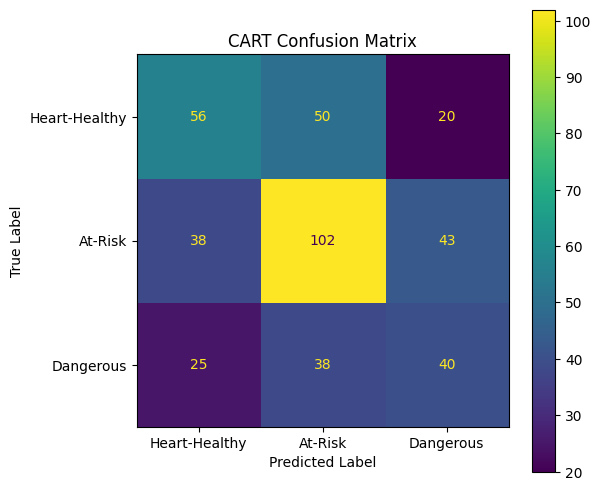

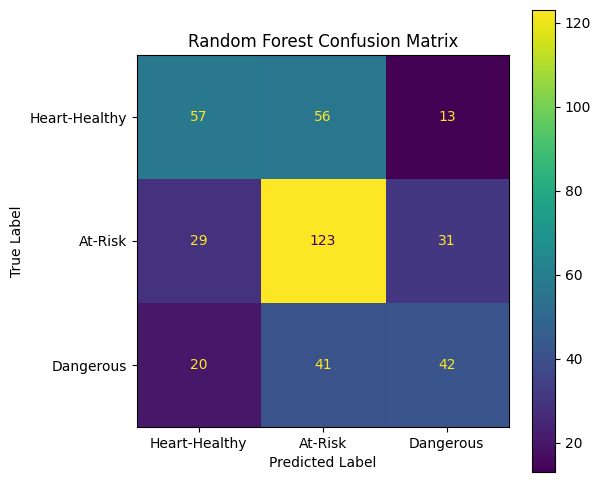

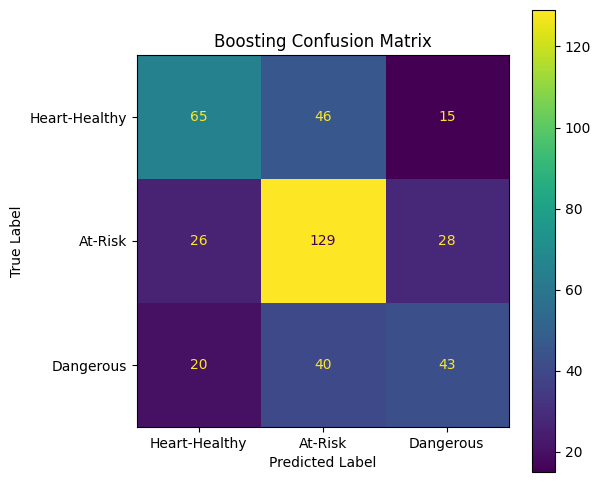

In [42]:
### DO NOT EDIT FOR YOUR BENEFIT
fig, ax = plt.subplots(figsize=(6,6))
cm_CART_display.plot(ax=ax)
ax.set_title("CART Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticklabels(["Heart-Healthy", "At-Risk", "Dangerous"])
ax.set_yticklabels(["Heart-Healthy", "At-Risk", "Dangerous"])
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
cm_RF_display.plot(ax=ax)
ax.set_title("Random Forest Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticklabels(["Heart-Healthy", "At-Risk", "Dangerous"])
ax.set_yticklabels(["Heart-Healthy", "At-Risk", "Dangerous"])
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
cm_Boosting_display.plot(ax=ax)
ax.set_title("Boosting Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticklabels(["Heart-Healthy", "At-Risk", "Dangerous"])
ax.set_yticklabels(["Heart-Healthy", "At-Risk", "Dangerous"])
plt.show()

**ANSWER**:


---



## Part 10: The Final Boss: Maximizing Performance (6 points)

Decision trees are incredibly powerful for data with nonlinear relationships. Among the reasons for this is the customizability of hyperparameters and design choices that yield a high variety of trees. Your task is to reach a test classification accuracy of 57% or higher. You may use any decision tree we covered in lab. Among the things you can vary are:

1.   Learning Rate
2.   Number of Estimators (Trees)
3.   Tree Depth
4.   Min Samples in Each Leaf
5.   Max Features Considered per Tree
6.   Min Impurity Decrease

You may find the documentation of each class helpful to identify parameters to change. Please call the model you use `final_model` so that it passes the test cases.


**Note**: Including HDL as a feature will result in a 0.

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
selected_features = ["WaistSize", "Height", "BMI", "Age", "Weight"]  # Top 5 features

X = my_df[selected_features]
y = my_df["Level"]

final_model = GradientBoostingClassifier(
    n_estimators=1000,            # Increased capacity for complex patterns
    learning_rate=0.01,          # Slower learning for better generalization
    max_depth=3,                 # Deeper trees to capture interactions
    min_samples_leaf=5,         # Larger leaf size regularization
    max_features='sqrt',         # Random feature subset selection
    subsample=0.9,               # Stochastic gradient boosting
    min_impurity_decrease=0.75,
    random_state=42
)

final_model.fit(X_train, y_train)
final_accuracy = final_model.score(X_test, y_test)
print(final_accuracy)

0.5825242718446602


In [44]:
final_accuracy = final_model.score(X_test, y_test)
assert final_accuracy > 0.57
print("You did it! :)")

You did it! :)
